# ITSLIVE, RETREAT compare

Comparing RETREAT, ITSLIVE data processed and prepared in `itslive_43.ipynb` and `retreat_43.ipynb`. stored in `/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/` dirs are `44_retreat_clipped` and `44_itslive_clipped`

In [1]:
import xarray as xr 
import numpy as np
import pandas as pd
import geopandas as gpd 
import rioxarray as rio
import rioxarray.merge as merge
import urllib.request
import json
import os
from osgeo import gdal
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.stats import sem
import scipy
import statsmodels
from statsmodels.stats.stattools import medcouple
import math
import seaborn as sns
from matplotlib.dates import date2num
from datetime import datetime

In [2]:
import sys
sys.path.insert(0, '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/retreat/')

import retreat_tools
import itslive_tools
import general_tools

## Read in ITSLIVE data

In [3]:
itslive_path = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/44_itslive_clipped/'

In [4]:
itslive_files = os.listdir(itslive_path)

In [5]:
itslive_files = [f for f in itslive_files if 'rgi' not in f]

In [6]:
len(itslive_files)

32

In [10]:
key_ls, val_ls = [],[]

for f in range(len(itslive_files)):
    
    glacier = itslive_files[f][3:-3]
    key_ls.append(glacier)
    ds = xr.open_dataset(os.path.join(itslive_path, itslive_files[f]))
    val_ls.append(ds)
                         

In [11]:
itslive_dict = dict(zip(key_ls, val_ls))

In [12]:
len(itslive_dict.keys())

32

In [13]:
ds = itslive_dict['RGI60-15.03976']

In [14]:
ds = ds.sortby('mid_date', ascending=True)

In [15]:
#add a time separation (in days) var
def add_time_separation(ds):
    
    ds['img_separation'] = (ds.acquisition_date_img1 - ds.acquisition_date_img2).astype('timedelta64[D]') / np.timedelta64(1,'D')*-1
    return ds

In [16]:
ds = add_time_separation(ds)

In [69]:
ds_short = ds.where(ds.img_separation <= 90, drop=True)

In [18]:
ds_long = ds.where(ds.img_separation > 90., drop=True)

## ITSLIVE processing

- calc MC statistic for each time step
- apply adjusted boxplot 

## end of day 4/5: stuck on vectorizing adjusted boxplot
- i think need to use map_blocks() , may have it working (maybe)

In [70]:
ds_short_vxy = ds_short.v.stack(xy=('x','y'))

In [71]:
def mc(arr, axis='xy'):
    #print(f'arr: {arr.shape}')
    
    arr = np.reshape(arr,(len(arr)))
    #print(arr.shape)
    s = pd.Series(arr).dropna()
    #print(s.shape)
    mc = medcouple(s)
    #print(mc)
    #print('----')
    
    return mc

def calc_q1(arr, axis=None):
    return np.nanpercentile(arr, 25)
def calc_q3(arr, axis=None):
    return np.nanpercentile(arr, 75)

In [ ]:
def add_MC_var(ds):
    
    ds_vxy = ds_short.v.stack(xy=('x','y'))
    
    res_mc = xr.apply_ufunc(mc,
                     ds_vxy,
                     input_core_dims=[['xy'],],
                     #exclude_dims=set(('xy',)),
                     #output_core_dims=[['xy']],
                     vectorize=True,
                    )
    ds['MC_v'] = res_mc
    
    return ds


In [106]:
mc(ds_short_vxy.isel(mid_date=0))

array(0.16666667)

In [72]:
res_mc = xr.apply_ufunc(mc,
                     ds_short_vxy,
                     input_core_dims=[['xy'],],
                     #exclude_dims=set(('xy',)),
                     #output_core_dims=[['xy']],
                     vectorize=True,
                    )

In [73]:
res_q1 = xr.apply_ufunc(calc_q1,
                     ds_short_vxy,
                     input_core_dims=[['xy'],],
                     #exclude_dims=set(('xy',)),
                     #output_core_dims=[['xy']],
                     vectorize=True,
                    )

In [74]:
res_q3 = xr.apply_ufunc(calc_q3, 
                        ds_short_vxy, 
                        input_core_dims=[['xy'],],
                        vectorize=True,
                       )

In [75]:
ds_short['MC_v'] = res_mc
ds_short['q1_v'] = res_q1
ds_short['q3_v'] = res_q3

In [76]:
ds_short

<xarray.Dataset>
Dimensions:                    (mid_date: 2885, y: 31, x: 26)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2013-04-09T16:49:00....
  * x                          (x) float64 3.079e+05 3.08e+05 ... 3.109e+05
  * y                          (y) float64 3.139e+06 3.139e+06 ... 3.135e+06
    mapping                    int64 0
    crs                        int64 0
Data variables: (12/68)
    acquisition_date_img1      (mid_date) datetime64[ns] 2013-03-26T04:48:19 ...
    acquisition_date_img2      (mid_date) datetime64[ns] 2013-04-24T04:49:42 ...
    autoRIFT_software_version  (mid_date) object 1.3.1 1.3.1 ... 1.4.0 1.4.0
    chip_size_height           (mid_date, y, x) float32 nan nan nan ... nan nan
    chip_size_width            (mid_date, y, x) float32 nan nan nan ... nan nan
    date_center                (mid_date) datetime64[ns] 2013-04-09T16:49:00....
    ...                         ...
    z2_sem                     (mid_date) float64 1.939 2.587 ... 9.03 25.46
    z3_sem                     (mid_date) float64 2.865 1.985 ... 6.932 10.95
    img_separation             (mid_date) float64 30.0 62.0 33.0 ... 6.0 6.0
    MC_v                       (mid_date) float64 0.1667 0.1538 ... 0.1094 -0.08
    q1_v                       (mid_date) float64 22.0 22.0 44.0 ... 59.0 46.0
    q3_v                       (mid_date) float64 51.0 50.0 ... 149.0 103.5
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:22
    date_updated:               14-Jun-2022 04:37:22
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [215]:
def adj_boxplot(v):
    '''function to calculate adjusted boxplot for skewed distributes (from Hubert + Vanderviernan 2008) 
    for outlier detection of velocity data
    '''
    #print(v.shape)
    #print('vmin: ', np.nanmin(v))
    #print('vmax: ', np.nanmax(v))
    v_stack = v.flatten()
    #print(len(v_stack))
    
    q1 = np.nanpercentile(v_stack, 25)
    #print(q1)
    q3 = np.nanpercentile(v_stack, 75) 
    #print(q3)
    iqr = (q3 - q1)
    
    #arr = np.reshape(v_stack,(len(v_stack)))
    #print(arr.shape)
    s = pd.Series(v_stack).dropna()
    #print(s.shape)
    mc = medcouple(s)
    #print(mc)
    
    iqr = (q3-q1)
    if mc >= 0:
        lb = q1 - (1.5*math.exp(-4*mc)*iqr)
        #print('lower bound: ', lb)
        ub = q3 + (1.5*math.exp(3*mc)*iqr)
        #print('upper bound: ', ub)
    elif mc < 0:
        #print('neg MC')
        lb = q1 - (1.5*math.exp(-3*mc)*iqr)
        #print('lower bound: ', lb)
        ub = q3 + (1.5*math.exp(4*mc)*iqr)
        #print('upper bound: ', ub)
    
    filtered = np.where(np.logical_and((lb <= v),(v <= ub)), v, np.nan)
    #print('filtered shape: ', filtered.shape)
    #print('filtered min is: ',np.nanmin(filtered))
    #print('filtered max is: ', np.nanmax(filtered))
    #print(type(filtered))
    return filtered
        

In [216]:
v_filtered = xr.apply_ufunc(adj_boxplot, ds_short.v,
                        input_core_dims = [['x','y']],
                        output_core_dims =[['x','y']],
                        exclude_dims = set(('x','y')),
                        vectorize=True,
                                           )

In [252]:
filtered_flat = v_filtered.stack(xyt = ('x','y','mid_date'))

In [255]:
np.count_nonzero(~np.isnan(filtered_flat.data))

970085

In [256]:
unfiltered_flat = ds_short.v.stack(xyt=('x','y','mid_date'))

In [257]:
np.count_nonzero(~np.isnan(unfiltered_flat.data))

991345

In [267]:
np.nanpercentile(unfiltered_flat.data, 90)

102.0

In [266]:
np.nanpercentile(filtered_flat.data, 90)

101.0

In [229]:
np.count_nonzero(num_invalid_filtered.data == True)

1355225

In [230]:
np.count_nonzero(num_invalid_filtered.data != True)

970085

In [168]:
ds_short['v_filtered'] = v_filtered

In [202]:
ds_short.v.count()

<xarray.DataArray 'v' ()>
array(991345)
Coordinates:
    mapping  int64 0
    crs      int64 0

In [232]:
ds_short.v.isnull().where(ds_short.v.isnull() == True, drop=True).count()

<xarray.DataArray 'v' ()>
array(1333965)
Coordinates:
    mapping  int64 0
    crs      int64 0

In [211]:
ds_short.v_filtered.isnull().where(ds_short.v_filtered.isnull() == True, drop=True).count()

<xarray.DataArray 'v_filtered' ()>
array(1355225)
Coordinates:
    mapping  int64 0
    crs      int64 0

In [231]:
970085 / 2325310

0.41718523551698483

In [205]:
2885*26*31

2325310

In [317]:
math.sqrt(ds_short.v_filtered.count().data)

984.9289314463252

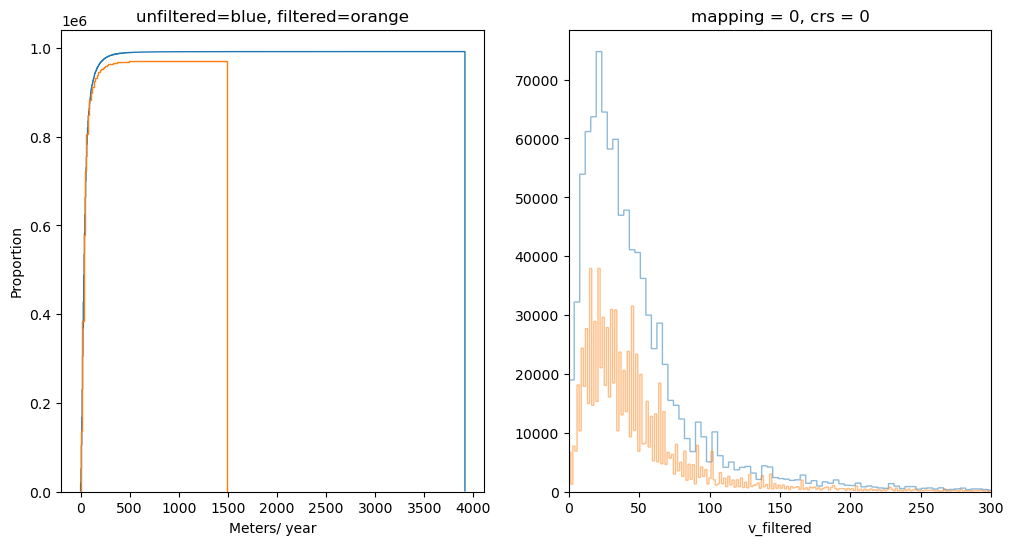

In [328]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
xr.plot.hist(ds_short.v, bins = 1000, cumulative= True, histtype='step', ax=axs[0])
xr.plot.hist(ds_short.v_filtered, bins=100, cumulative=True, histtype='step', ax=axs[0])
#axs[0].axvline(x=300, color='red')
#axs[0].text(s='0.9', y=0.92e6, x=2000)
#axs[0].text(s='300 m/y', y=.2e6, x=400)
#axs[0].axhline(y=.9e6, color='red')
xr.plot.hist(ds_short.v,  bins = 1000, histtype='step', ax=axs[1], alpha = 0.5)
xr.plot.hist(ds_short.v_filtered, bins = 1000, histtype='step', ax=axs[1], alpha = 0.5);
#axs[1].set_xlim(300, 1500)
axs[1].set_xlim(0,300);
axs[0].set_ylabel('Proportion')
axs[0].set_xlabel('Meters/ year')
axs[0].set_title('unfiltered=blue, filtered=orange');
#axs[1].set_ylim(0,1000);
#axs[1].set_ylim(0,500);

In [235]:
1355225 - 1333965

21260

In [236]:
991345 - 970085

21260

In [247]:
ds_short.v.std().data / np.sqrt(991345)

0.06351772263872235

In [246]:
ds_short.v_filtered.std().data / np.sqrt(970085)

0.05501294945255889

In [183]:
ds_short.mi.max()

<xarray.DataArray 'v_filtered' ()>
array(1486., dtype=float32)
Coordinates:
    mapping  int64 0
    crs      int64 0

In [ ]:
def outlier_detection_adj_boxplot(ds): #v variable hardcoded
       
    v_filtered = xr.apply_ufunc(adj_boxplot, ds_short.v,
                        input_core_dims = [['x','y']],
                        output_core_dims =[['x','y']],
                        exclude_dims = set(('x','y')),
                        vectorize=True, )
    ds['v_filtered'] = v_filtered
    
    return ds

In [63]:
np.count_nonzero(~np.isnan(ds_short.isel(mid_date=1).v.where(ds_short.isel(mid_date=1).v <= 127.716, drop=True)))

401

In [62]:
np.count_nonzero(~np.isnan(ds_short.isel(mid_date=1).v))

403

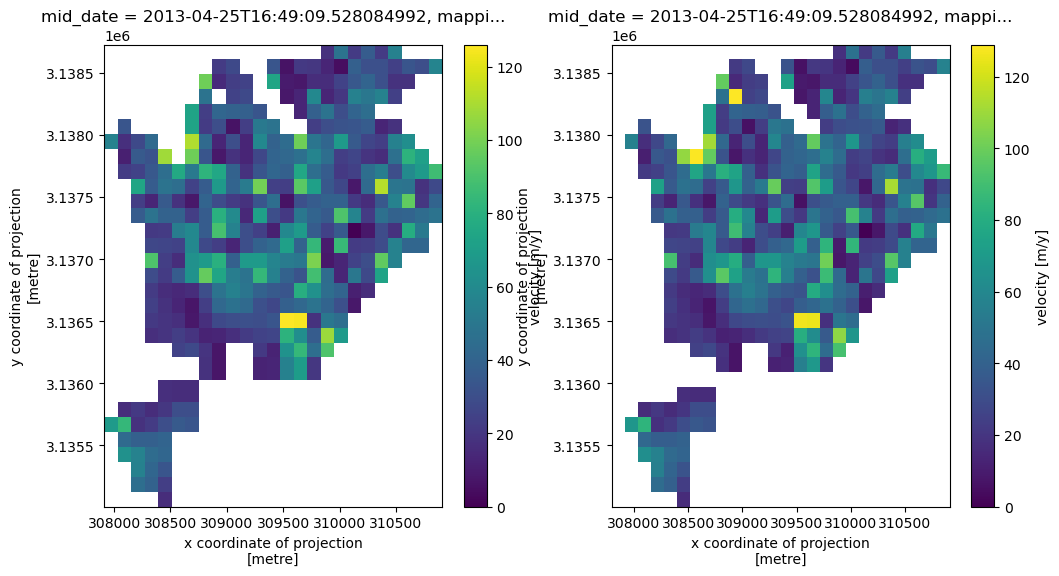

In [61]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
ds_short.isel(mid_date=1).v.where(ds_short.isel(mid_date=1).v <= 127.716, drop=True).plot(ax=axs[0])
ds_short.isel(mid_date=1).v.plot(ax=axs[1])

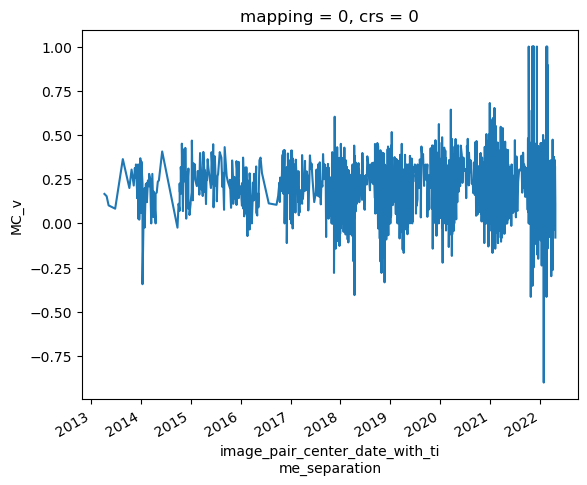

In [58]:
ds_short.MC_v.plot()

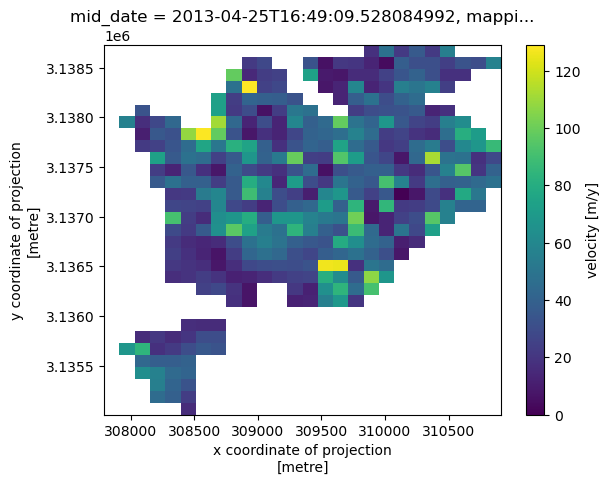

In [56]:
ds_short.isel(mid_date=1).v.plot()

In [24]:
def calc_q1(arr, axis=None):
    return np.nanpercentile(arr, 25)
def calc_q3(arr, axis=None):
    return np.nanpercentile(arr, 75)

In [91]:
def calc_upper_lower_bounds(ds): 
    
    if ds.MC_v < 0:
        print: ds.MC_v

        lower_bound = q1 - (1.5*math.exp(-4*ds.MC_v)*iqr)
        upper_bound = q3 + (1.5*math.exp(3*ds.MC_v)*iqr)

    elif ds_gb.MC_v > 0:

        lower_bound = q1 - (1.5*math.exp(-3*ds.MC_v)*iqr)
        upper_bound = q3 + (1.5*math.exp(4*ds.MC_v)*iqr)
    print(lower_bound, upper_bound)
    return upper_bound, lower_bound
    
    

In [92]:
ds_short['upper_bound'] = calc_upper_lower_bounds(ds_short)[0]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [85]:
res_q1 = xr.apply_ufunc(calc_q1,
                     ds_short_vxy,
                     input_core_dims=[['xy'],],
                     #exclude_dims=set(('xy',)),
                     #output_core_dims=[['xy']],
                     vectorize=True,
                    )

In [86]:
res_q3 = xr.apply_ufunc(calc_q3, 
                        ds_short_vxy, 
                        input_core_dims=[['xy'],],
                        vectorize=True,
                       )

In [87]:
ds_short['q1_v'] = res_q1
ds_short['q3_v'] = res_q3

In [34]:
unique_steps = np.arange(len(ds_short.mid_date))

In [35]:
unique_steps

array([   0,    1,    2, ..., 2882, 2883, 2884])

In [36]:
ds_short['step_int'] = (('mid_date'), unique_steps)

In [37]:
ds_short = ds_short.assign_coords({'step_int':ds_short.step_int})

In [38]:
ds_short

<xarray.Dataset>
Dimensions:                    (mid_date: 2885, y: 31, x: 26)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2013-04-09T16:49:00....
  * x                          (x) float64 3.079e+05 3.08e+05 ... 3.109e+05
  * y                          (y) float64 3.139e+06 3.139e+06 ... 3.135e+06
    mapping                    int64 0
    crs                        int64 0
    step_int                   (mid_date) int64 0 1 2 3 ... 2881 2882 2883 2884
Data variables: (12/68)
    acquisition_date_img1      (mid_date) datetime64[ns] 2013-03-26T04:48:19 ...
    acquisition_date_img2      (mid_date) datetime64[ns] 2013-04-24T04:49:42 ...
    autoRIFT_software_version  (mid_date) object 1.3.1 1.3.1 ... 1.4.0 1.4.0
    chip_size_height           (mid_date, y, x) float32 nan nan nan ... nan nan
    chip_size_width            (mid_date, y, x) float32 nan nan nan ... nan nan
    date_center                (mid_date) datetime64[ns] 2013-04-09T16:49:00....
    ...                         ...
    z2_sem                     (mid_date) float64 1.939 2.587 ... 9.03 25.46
    z3_sem                     (mid_date) float64 2.865 1.985 ... 6.932 10.95
    img_separation             (mid_date) float64 30.0 62.0 33.0 ... 6.0 6.0
    MC_v                       (mid_date) float64 0.1667 0.1538 ... 0.1094 -0.08
    q1_v                       (mid_date) float64 22.0 22.0 44.0 ... 59.0 46.0
    q3_v                       (mid_date) float64 51.0 50.0 ... 149.0 103.5
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:22
    date_updated:               14-Jun-2022 04:37:22
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [401]:
a = ds_short.groupby(ds_short.step_int).mean()

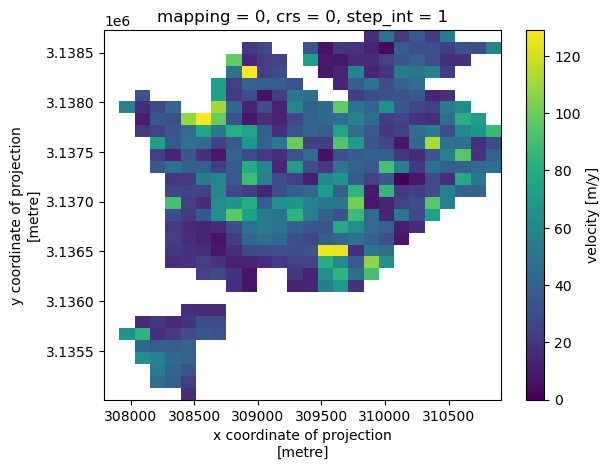

In [404]:
a.v.isel(step_int=1).plot()

In [114]:
def adjusted_boxplot(ds, axis=None):
    print(ds.dims)
    
    #ds_gb = ds.groupby(ds.step_int).mean()
    ds_gb = ds
    
    ds_gb.q1_v
    print(q1)
    q3 = ds_gb.q3_v
    print(q3)
    iqr = (ds_gb.q3_v - ds_gb.q1_v)
    print(iqr)
    
    try:
        if ds_gb.MC_v < 0:
            print(ds_gb.MC_v)

            lower_bound = q1 - (1.5*math.exp(-4*ds_gb.MC_v)*iqr)
            upper_bound = q3 + (1.5*math.exp(3*ds_gb.MC_v)*iqr)

        elif ds_gb.MC_v > 0:
            print(ds_gb.MC_v)

            lower_bound = q1 - (1.5*math.exp(-3*ds_gb.MC_v)*iqr)
            upper_bound = q3 + (1.5*math.exp(4*ds_gb.MC_v)*iqr)
        print(lower_bound, upper_bound)
        filtered = ds.where(np.logical_and(ds.v >= lower_bound, ds.v <=upper_bound), drop=True)

        return filtered
    except:
        print('something went wrong')

In [115]:
def adjusted_boxplot_wrapper(ds):
    print(ds.dims)
    ds['filtered'] = ds.map_blocks(adjusted_boxplot, template=ds.v)
    
    return ds

In [116]:
#ds_short = ds_short.chunk({'mid_date':1})

In [117]:
test = adjusted_boxplot_wrapper(ds_short.isel(mid_date=14))

Frozen({'y': 31, 'x': 26})


In [118]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

test.v.plot(ax=axs[0])
test.filtered.

<xarray.Dataset>
Dimensions:                    (y: 31, x: 26)
Coordinates:
    mid_date                   datetime64[ns] 2013-12-12T04:49:23.028084992
  * x                          (x) float64 3.079e+05 3.08e+05 ... 3.109e+05
  * y                          (y) float64 3.139e+06 3.139e+06 ... 3.135e+06
    mapping                    int64 0
    crs                        int64 0
Data variables: (12/70)
    acquisition_date_img1      datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    acquisition_date_img2      datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    autoRIFT_software_version  object dask.array<chunksize=(), meta=np.ndarray>
    chip_size_height           (y, x) float32 dask.array<chunksize=(31, 26), meta=np.ndarray>
    chip_size_width            (y, x) float32 dask.array<chunksize=(31, 26), meta=np.ndarray>
    date_center                datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    ...                         ...
    img_separation             float64 dask.array<chunksize=(), meta=np.ndarray>
    skew_v                     float64 dask.array<chunksize=(), meta=np.ndarray>
    MC_v                       float64 dask.array<chunksize=(), meta=np.ndarray>
    q1_v                       float64 dask.array<chunksize=(), meta=np.ndarray>
    q3_v                       float64 dask.array<chunksize=(), meta=np.ndarray>
    filtered                   (y, x) float32 dask.array<chunksize=(31, 26), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:22
    date_updated:               14-Jun-2022 04:37:22
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [97]:
ds_filtered = ds_short.map_blocks(adjusted_boxplot_wrapper, template = ds_short.v) #I think this works????

In [98]:
ds_filtered = ds_filtered.compute() #getting some sort of error here. not suer why its printing multiple dims for each time step? and it seems to be failing on time step 13, looks like lower_bound isn't being calculated?

Frozen({'mid_date': 1, 'y': 31, 'x': 26})
Frozen({'mid_date': 1, 'y': 31, 'x': 26})
Frozen({'mid_date': 1, 'y': 31, 'x': 26})
Frozen({'mid_date': 1, 'y': 31, 'x': 26})
-72.77726967397632 171.34665301699025
0.4187843185537581 101.97016554014216
Frozen({'mid_date': 1, 'y': 31, 'x': 26})
Frozen({'mid_date': 1, 'y': 31, 'x': 26})
something went wrong
Frozen({'mid_date': 1, 'y': 31, 'x': 26})
Frozen({'mid_date': 1, 'y': 31, 'x': 26})
-2.0936359850239104 110.39412684391351


ValueError: Result from applying user function does not contain data variables {<this-array>}.

In [368]:
bounds = adjusted_boxplot(ds_short.isel(mid_date=1))

In [311]:
bounds[0]

-4.473153837062231

In [312]:
bounds[1]

127.71546199630782

In [313]:
filter1 = ds_short.isel(mid_date=1).where(np.logical_and(ds_short.isel(mid_date=1).v >= bounds[0], ds_short.isel(mid_date=1).v <=bounds[1]), drop=True)

In [316]:
np.count_nonzero(filter1.v.data)

749

In [317]:
np.count_nonzero(ds_short.isel(mid_date=1).v.data)

805

In [345]:
unfiltered1_df = ds_short.isel(mid_date=1).v.to_dataframe()

In [360]:
filter1_df = filter1.v.to_dataframe()

In [361]:
filter1_df = filter1.rename({'v':'v_filtered'})

In [362]:
unfiltered1_df = unfiltered1_df.rename({'v':'v_unfiltered'})

In [363]:
filter1_df

<xarray.Dataset>
Dimensions:                    (y: 30, x: 25)
Coordinates:
    mid_date                   datetime64[ns] 2013-04-25T16:49:09.528084992
  * x                          (x) float64 3.08e+05 3.081e+05 ... 3.109e+05
  * y                          (y) float64 3.139e+06 3.139e+06 ... 3.135e+06
    mapping                    int64 0
    crs                        int64 0
Data variables: (12/68)
    acquisition_date_img1      (y, x) datetime64[ns] NaT NaT NaT ... NaT NaT NaT
    acquisition_date_img2      (y, x) datetime64[ns] NaT NaT NaT ... NaT NaT NaT
    autoRIFT_software_version  (y, x) object nan nan nan nan ... nan nan nan nan
    chip_size_height           (y, x) float32 nan nan nan nan ... nan nan nan
    chip_size_width            (y, x) float32 nan nan nan nan ... nan nan nan
    date_center                (y, x) datetime64[ns] NaT NaT NaT ... NaT NaT NaT
    ...                         ...
    z2_sem                     (y, x) float64 nan nan nan nan ... nan nan nan
    z3_sem                     (y, x) float64 nan nan nan nan ... nan nan nan
    img_separation             (y, x) float64 nan nan nan nan ... nan nan nan
    MC_v                       (y, x) float64 nan nan nan nan ... nan nan nan
    q1_v                       (y, x) float64 nan nan nan nan ... nan nan nan
    q3_v                       (y, x) float64 nan nan nan nan ... nan nan nan
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:22
    date_updated:               14-Jun-2022 04:37:22
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [330]:
filter1_df = filter1.v.to_dataframe()

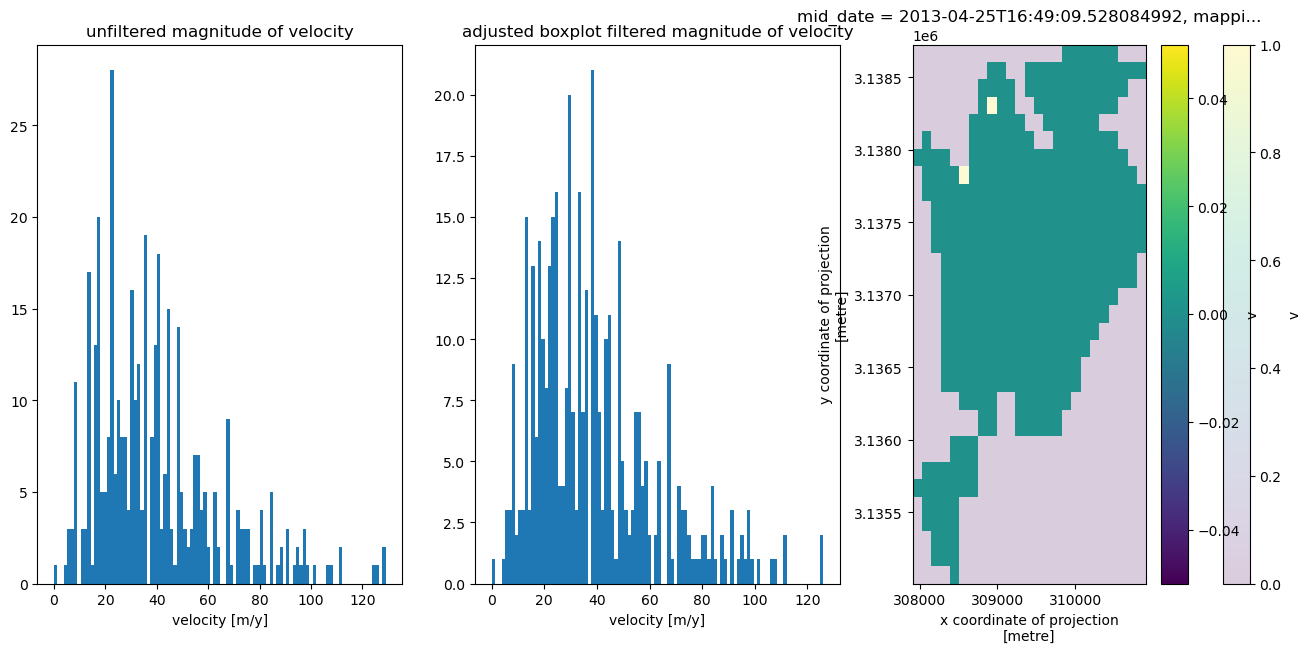

In [325]:
fig, axs = plt.subplots(ncols=3, figsize=(16,7))

filter1.v.plot.hist(ax=axs[1], bins=100)
ds_short.isel(mid_date=1).v.plot.hist(ax=axs[0], bins=100)
axs[0].set_title('unfiltered magnitude of velocity')
axs[1].set_title('adjusted boxplot filtered magnitude of velocity')
ds_short.isel(mid_date=1).v.notnull().plot(alpha = 0.2, ax=axs[2])
(filter1.v - ds_short.isel(mid_date=1).v).plot(ax=axs[2]);